# PDE-FIND for the Korteweg–de Vries Equation

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on the Korteweg–de Vries equation.
$$
u_t + 6uu_x + u_{xxx} = 0
$$
The solution given is a two soliton solution without interaction between them.  It also works fine if they do interact.

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import sys; sys.path.append('..')
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from PDE_FIND import *
import scipy.io as sio

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load data
data = sio.loadmat('../Datasets/kdv.mat')

In [3]:
U = real(data['usol'])
x = data['x'][0]
t = data['t'][:,0]
n,m = U.shape #512, 201
dt = t[1]-t[0]
dx = x[1]-x[0]

Text(0.5, 0, 't')

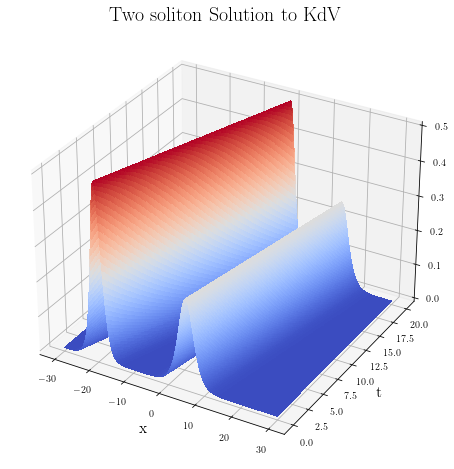

In [4]:
X, T = np.meshgrid(x, t)
fig = figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, T, U.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title('Two soliton Solution to KdV', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)

## Construct $\Theta (U)$ and compute $U_t$

The function build_linear_system does this for us.  We specify <br>
D = highest derivative to appear in $\Theta$  <br>
P = highest degree polynomial of $u$ to appear in $\Theta$ (not including multiplication by a derivative.  <br>
time_diff and space_diff taken via finite differences

Printed out is a list of candidate functions for the PDE.  Each is a column of $\Theta (U)$

In [5]:
Ut, R, rhs_des = build_linear_system(U, dt, dx, D=3, P=2, time_diff = 'FD', space_diff = 'FD')
['1']+rhs_des[1:]

['1',
 'u',
 'u^2',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}']

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [6]:
# Solve with STRidge using 2-norm normalization
w = TrainSTRidge(R,Ut,10**-5,5)
print ("PDE derived using STRidge")
print_pde(w, rhs_des)

..\PDE_FIND.py:443: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
..\PDE_FIND.py:589: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
..\PDE_FIND.py:615: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old,

PDE derived using STRidge
u_t = (-5.956504 +0.000000i)uu_{x}
    + (-0.988106 +0.000000i)u_{xxx}
   


In [7]:
err = abs(np.array([(6 - 5.956504)*100/6, (1 - 0.988106)*100]))
print (mean(err))
print (std(err))

0.9571666666666663
0.23223333333332968


## Now identify the same dynamics but with added noise.

The only difference from above is that finite differences work poorly for noisy data so here we use polynomial interpolation.  With deg_x or deg_t and width_x or width_t we specify the degree number of points used to fit the polynomials used for differentiating x or t.  Unfortunately, the result can be sensitive to these.

In [8]:
numpy.random.seed(0)
Un = U + 0.01*std(U)*np.random.randn(n,m)

In [9]:
Utn, Rn, rhs_des = build_linear_system(Un, dt, dx, D=3, P=2, 
                                 time_diff = 'poly', space_diff = 'poly', 
                                 width_x = 20, width_t = 10, deg_x = 5)

In [10]:
# Solve with STRidge using 2-norm normalization
wn = TrainSTRidge(Rn,Utn,10**-5,5)
print ("PDE derived using STRidge")
print_pde(wn, rhs_des)

PDE derived using STRidge
u_t = (-6.152522 +0.000000i)uu_{x}
    + (-1.124033 +0.000000i)u_{xxx}
   


In [11]:
err = abs(np.array([(6 - 6.152522)*100/6, (1 - 1.124033)*100]))
print (mean(err))
print (std(err))

7.4726666666666715
4.930633333333334


In [12]:
# Solve with Lasso.  It doesn't work :(
wn = Lasso(Rn,Utn,10)
print ("PDE derived using Lasso")
print_pde(wn, rhs_des)

PDE derived using Lasso
u_t = (-0.283023 +0.000000i)u_{x}
   
